In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tx_fast_hydrology.muskingum import Muskingum, ModelCollection
from tx_fast_hydrology.simulation import AsyncSimulation
import time

Deal with ESRI's BS format

In [2]:
# Step 1: Load the Esri-like JSON
with open("huc2_12_nhd.json") as f:
    esri_data = json.load(f)

# Step 2: Load the standard GeoJSON from QGIS
with open("huc2_12_nhd_lake.geojson") as f:
    lake_data = json.load(f)

# Step 3: Add the 'Lake' attribute from the standard GeoJSON to the Esri-like JSON
for esri_feature, lake_feature in zip(esri_data["features"], lake_data["features"]):
    lake_value = lake_feature["properties"]["Lake"]
    esri_feature["attributes"]["Lake"] = lake_value

# Step 4: Save the updated Esri-like JSON
with open("updated_huc2_12_nhd.json", "w") as f:
    json.dump(esri_data, f, indent=1)

print("Updated Esri-like JSON saved as 'updated_huc2_12_nhd.json'.")

Updated Esri-like JSON saved as 'updated_huc2_12_nhd.json'.


In [3]:
with open("updated_huc2_12_nhd.json") as basin:
    d = json.load(basin)

In [54]:
# Entry nodes
comids = [
    1077861,
    1109679,
    # 1111403,           1111409,
    1111417,
    1113963,
    1114297,
    1114299,
    1114345,
    1143224,
    1143312,
    1143314,
    1143316,
    1158939,
    1166519,
    1260139,
    1262665,
    1262689,
    1262851,
    1262853,
    1268222,
    1279694,
    1440413,
    1454851,
    # 1468432,
    1468436,
    # 1477691,            1477695,
    1477697,
    1484774,
    1513293,
    1515141,
    1515205,
    1523893,
    1524321,
    1524339,
    1572612,
    # 1576434,
    1608986,
    1612222,
    1615800,
    1619581,
    1622685,
    1637437,
    1640223,  # 2572334,
    3121538,
    3123146,
    3123804,
    3125214,
    3154801,
    3168766,
    3763134,
    3766322,
    3836435,
    3838857,
    4133089,
    5275740,
    5275810,
    5275814,
    5280888,
    5494668,
    5512484,
    5513780,
    5520002,
    5522366,
    # 5531602,
    5541400,
    5553609,
    5558000,
    5559368,
    5559384,
    5592244,
    5592482,
    5654670,
    5683653,
    5686225,
    # 5702855,
    5714875,
    5719546,
    5721363,
    5726391,
    5728811,
    # 5735543,
    5746002,
    5746564,
    5756826,  # 5757818,
    5772131,
    5779279,
    # 5780387,
    5790024,
    7843181,
    7865454,
    8328606,
    8328658,
    9352003,
    9354366,
    9354378,
    10629591,
    10647715,
    10647767,
    10648457,
    10661030,  # 10663428,
    10664158,
    10840558,
    10891985,
    10893317,
    13700083,
    13718551,
    14023862,
    14034489,
    942110009,
]

In [ ]:
# Filter features in geojson where 'COMID' matches a value in comids and 'Lake' is not -9999
features_with_lake = [
    feature
    for feature in d["features"]
    if str(feature["attributes"]["COMID"]) in comids
    and feature["attributes"].get("Lake", -9999) != -9999
]

# Extract the COMIDs of these features
comids_with_lake = [feature["attributes"]["COMID"] for feature in features_with_lake]

print(f"COMIDs with 'Lake' attribute not equal to -9999: {comids_with_lake}")

#### Clean the geojson of the lakes

In [4]:
# Step 1: Build helper structures
from collections import defaultdict

streams_by_lake = defaultdict(list)
to_id_map = {
    stream["attributes"]["COMID"]: stream["attributes"]["toCOMID"] for stream in d["features"]
}

# Group streams by lake
for stream in d["features"]:
    lake_id = stream["attributes"]["Lake"]
    if lake_id != -9999:
        streams_by_lake[lake_id].append(stream)

# Step 2: Find outflow stream for each lake
lake_outflows = {}
for lake_id, streams in streams_by_lake.items():
    outflow_candidates = {stream["attributes"]["COMID"] for stream in streams}
    for stream in streams:
        if stream["attributes"]["toCOMID"] not in outflow_candidates:
            lake_outflows[lake_id] = stream["attributes"]["toCOMID"]
            break

# Step 3: Redirect inflows to the lake outflow stream
for lake_id, outflow_id in lake_outflows.items():
    # Get all COMIDs of streams inside the lake
    lake_comids = {stream["attributes"]["COMID"] for stream in streams_by_lake[lake_id]}

    # Redirect streams whose toCOMID points to any lake stream
    for stream in d["features"]:
        if stream["attributes"]["toCOMID"] in lake_comids:
            stream["attributes"]["toCOMID"] = outflow_id

# Step 4: Remove lake-associated streams
lakeless_features = [stream for stream in d["features"] if stream["attributes"]["Lake"] == -9999]

In [5]:
from copy import deepcopy

d2 = deepcopy(d)

d2["features"] = lakeless_features
output_file = "modified_network.json"

with open(output_file, "w") as f:
    json.dump(d2, f, indent=1)

In [6]:
nhd_path = "./modified_network.json"
with open(nhd_path) as basin:
    d = json.load(basin)

In [7]:
# Exit nodes
comids = [
    1077643,
    1078881,
    1078897,  # 1111369,
    1160745,  # new outfall
    1113965,
    1142744,
    1143298,
    1145428,
    1158941,
    1160619,
    1160719,
    1166607,
    1166621,
    1262851,
    1262905,
    1264655,
    1269780,
    1279648,
    1287711,
    1294198,
    1300456,
    1300458,  # 1306945,
    1268222,  # new outfall added
    1448010,
    1456323,
    1456345,  # 1468426,
    # 1468428,   1469612,
    1440413,  # new outfall added
    1475693,
    1475695,
    1475697,
    1477505,
    1479839,
    1494050,
    1508325,
    1515205,
    1515213,
    1515495,
    1523581,
    1523627,
    1572614,
    1572640,
    1576430,
    1609042,
    1612200,
    1615408,
    1623367,
    1623369,
    1632017,
    1640215,
    # 2572328,
    2572084,  # new outfall added
    2572780,
    3123150,
    3123710,
    3154805,
    # 3589578,
    1619581,  # new outfall added
    3766328,
    4133145,
    5256723,
    5256725,
    5275764,
    5280902,
    5293763,
    5487027,
    5499448,
    5499450,
    5507108,
    5514790,
    5514792,
    5521348,
    5523992,
    5525867,  # 5531596, 5531600,
    5523882,  # new outfall added
    5544034,
    5559336,
    5559442,
    5570839,
    5579047,
    5588526,
    5593582,
    5635929,
    5651989,
    5652493,
    5656548,
    5671495,
    5690898,
    5702833,
    # 5702865,
    5702763,  # new outfall added between two lakes
    5712877,
    5714893,
    5714895,
    5715109,
    5718726,
    5722367,
    5722371,
    5729263,  # 5735553,
    5738437,  # new outfall added
    5737005,
    5746014,
    5746512,
    5746592,
    5754392,  # 5757862,
    5779279,  # new outfall added
    5762659,
    5765169,
    5771837,
    # 5780397,
    5781161,  # new large outfall added
    5789878,
    5791934,
    7847707,
    7852413,
    7872307,
    7876612,
    8333590,
    8333624,
    9351055,
    9351103,
    9354358,
    9354366,
    9357548,  # 9535873,
    8328658,  # new outfall added
    9535875,
    10624041,
    10630401,
    10631455,
    10648495,
    10648627,
    10657909,
    10657911,
    10661028,
    10664258,
    10671447,
    10828988,
    10836114,
    10840560,
    10840568,
    13494837,
    13514834,
    13681329,
    13700659,
    14034073,
    14034081,
    14034505,
    942110011,
]

In [8]:
# comids = [str(comid) for comid in comids]
link_ids = [i["attributes"]["COMID"] for i in d["features"]]
reach_ids = link_ids
reach_ids = [int(x) for x in reach_ids]
site_indices = {idx: reach_ids.index(idx) for idx in sorted(comids)}

In [9]:
n_steps = 18

In [ ]:
model = Muskingum.from_nhd_geojson(output_file, create_state_space=False, sparse=True)

In [8]:
model.K[:] = 3600.0
model.X[:] = 0.29
model.compute_muskingum_coeffs()

In [11]:
date_range = pd.date_range(start="20240101", periods=n_steps, freq="1h", tz="utc")
p_t = pd.DataFrame(0.0 * np.ones((n_steps, model.n)), index=date_range)
p_t.columns = model.reach_ids

In [10]:
model.datetime = p_t.index[0] - pd.to_timedelta("1h")
model.save_state()

# Run single-basin model

In [ ]:
fig, ax = plt.subplots()

model.plot(ax=ax, c="b")

In [12]:
t1 = time.time()
model.init_states(o_t_next=np.ones(model.n))

outputs = {}
outputs[model.datetime] = model.o_t_next

for state in model.simulate_iter(p_t):
    o_t_next = state.o_t_next
    outputs[state.datetime] = o_t_next
ref_outputs = pd.DataFrame.from_dict(outputs, orient="index")
ref_outputs.columns = model.reach_ids
ref_outputs.index = pd.to_datetime(ref_outputs.index, utc=True)
t2 = time.time()

In [ ]:
print(f"Time elapsed: {t2 - t1}s")

In [ ]:
_ = plt.plot(ref_outputs.values)
plt.ylabel("Discharge (cms)")
plt.xlabel("Time (h)")
plt.title("Original model")

# Run multi-basin model

In [12]:
# Reset model
model = Muskingum.from_nhd_geojson("modified_network.json", create_state_space=False, sparse=True)
model.datetime = p_t.index[0] - pd.to_timedelta("1h")
model.init_states(o_t_next=np.ones(model.n))
model.save_state()

In [13]:
ix = np.asarray(list(site_indices.values()), dtype=int)
ix.sort()

In [14]:
model_collection = model.split(ix, create_state_space=False)

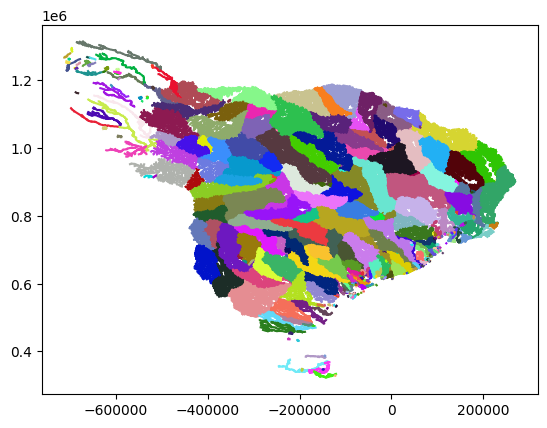

In [15]:
fig, ax = plt.subplots()

for index, model in model_collection.models.items():
    c = f"#{np.random.randint(0, 0xFFFFFF):06x}"
    model.plot(ax=ax, c=c)

In [19]:
simulation = AsyncSimulation(model_collection, p_t)

In [20]:
t1 = time.time()
multi_outputs = await simulation.simulate()
t2 = time.time()

In [21]:
simulation.load_states()

In [ ]:
print(f"Time elapsed: {t2 - t1}s")

In [23]:
final_outputs = pd.concat([output for output in multi_outputs.values()], axis=1)
final_outputs = final_outputs[ref_outputs.columns]
diff = ref_outputs - final_outputs

In [ ]:
_ = plt.plot(final_outputs.values)
plt.ylabel("Discharge (cms)")
plt.xlabel("Time (h)")
plt.title("Partitioned model")

In [ ]:
_ = plt.plot(diff.values)
plt.ylabel("Difference in discharge (cms)")
plt.xlabel("Time (h)")
plt.title("Difference between original and partitioned models")

In [16]:
model_collection.dump_model_collection("./huc8_no_lake.json")

In [17]:
model_collection = ModelCollection.from_file("./huc8_no_lake.json")

In [28]:
simulation = AsyncSimulation(model_collection, p_t)

In [29]:
t1 = time.time()
multi_outputs = await simulation.simulate()
t2 = time.time()

In [30]:
simulation.load_states()

In [31]:
final_outputs = pd.concat([output for output in multi_outputs.values()], axis=1)
final_outputs = final_outputs[ref_outputs.columns]
diff = ref_outputs - final_outputs

In [ ]:
_ = plt.plot(final_outputs.values)
plt.ylabel("Discharge (cms)")
plt.xlabel("Time (h)")
plt.title("Partitioned model")

In [ ]:
_ = plt.plot(diff.values)
plt.ylabel("Difference in discharge (cms)")
plt.xlabel("Time (h)")
plt.title("Difference between original and partitioned models")